## Imports

In this section, we'll import:
- `json` to parse the JSON documents
- `wordcloud` for the creation of a word cloud
- `matplotlib` to show the word cloud
- `lookup_json` (local) to allow the extraction of all lyrics from the tracks 

In [4]:
import os
import json
import re

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

import lookup_json

## Read the text

In [5]:
with open(os.curdir + "/../data/backup-tracks.json", 'r') as f:
    obj = json.load(f)

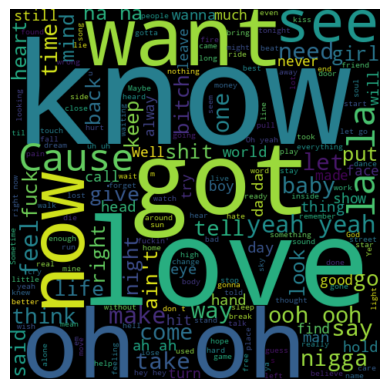

In [15]:
text = " ".join(lookup_json.dump(obj, ["*", "lyrics", "*", "content"]))

# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

## Descriptive Statistics

In [6]:
def get_present_values(obj, path):
    missing = []
    
    values = list(lookup_json.dump(obj, path, missing))
    present_values = list(filter(lambda x: x is not missing, values))
    
    return (present_values, values)

def print_missing(obj, path, name):
    present_values, values = get_present_values(obj, path)
    print(f"Missing {name} (%): {100 - (100 * len(present_values) / len(values))}")
    

In [8]:
print_missing(obj, ["*", "publishedAt"], "publishedAt")
print_missing(obj, ["*", "album"], "album")
print_missing(obj, ["*", "album", "image"], "album.image")
print_missing(obj, ["*", "lyrics", "0", "title"], "lyrics.0.title")
print_missing(obj, ["*", "duration"], "duration")
print_missing(obj, ["*", "publishedAt"], "publishedAt")

df_durations = pd.DataFrame(get_present_values(obj, ["*", "duration"])[0], columns=["duration"])
df_durations.describe()

Missing publishedAt (%): 68.26660988074957
Missing album (%): 8.801107325383299
Missing album.image (%): 3.3343451560931214
Missing lyrics.0.title (%): 12.787478705281089
Missing duration (%): 20.664395229982958
Missing publishedAt (%): 68.26660988074957
Hey

Haven't heard from you in a couple of months
But I'm out right now and I'm all fucked up
And you're callin' my phone and you're all alone
And I'm sensing some undertone
And I'm right here with all my friends
But you're sending me your new address
And I know we're done, I know we're through
But, God, when I look at you

My brain goes, "Ah"
Can't hear my thoughts (I cannot hear my thoughts)
Like blah-blah-blah (Blah, blah, blah, blah, blah, blah)
Should probably not
I should probably, probably not
I should probably, probably not

Seeing you tonight
It's a bad idea, right?
Seeing you tonight
It's a bad idea, right?
Seeing you tonight
It's a bad idea, right?
Seeing you tonight
Fuck it, it's fine

Yes, I know that he's my ex
But can't 

In [11]:
wc_regex = re.compile(r"\b\S+\b")

def get_words(text):
    yield from map(lambda x: x.group(), wc_regex.finditer(text))

In [14]:
for lyrics in lookup_json.dump(obj, ["*", "lyrics"]):
    text = "\n".join(lookup_json.dump(lyrics, ["*", "content"]))
    print(len(list(get_words(text))))

428
393
253
625
702
219
352
441
394
258
391
363
299
281
351
459
144
324
358
394
265
336
164
397
214
122
211
268
246
343
519
333
232
237
348
515
167
356
701
383
1149
316
232
90
437
405
161
373
268
485
368
205
484
167
249
236
127
724
438
308
108
136
228
161
411
140
550
393
459
352
403
870
193
426
297
258
410
387
401
301
409
392
296
379
293
504
313
698
276
462
319
120
183
201
123
301
332
399
622
253
316
265
710
118
184
489
409
228
258
297
135
426
271
492
779
467
286
465
259
397
309
176
289
310
283
591
482
350
637
437
857
559
330
307
285
265
143
277
363
175
260
383
254
228
344
445
364
260
390
504
335
305
546
356
458
390
679
180
279
144
94
159
763
626
73
201
172
484
214
378
606
480
444
218
816
218
301
408
269
198
557
73
430
303
103
118
557
288
633
483
217
451
362
239
340
295
497
760
506
94
38
788
238
277
479
185
448
534
109
403
599
93
511
266
492
451
298
333
344
458
415
269
253
208
322
658
667
213
321
436
195
221
350
140
268
418
280
298
711
336
154
635
238
174
139
193
207
476
695
99
411
562